In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
from sklearn import feature_selection as fs

In [3]:
file_path = '../DATA/PHENOTYPE/H2O2/H2O2_data.csv'
data = pd.read_csv(file_path,index_col=0)
data.head()

,H2O2,SSK1,SSK2,RIC8
SS-A837,2.0,1.0,1.0,1.0
SS-B307,0.5,0.0,0.0,1.0
SS-B310,0.0,1.0,0.0,1.0
SS-B311,4.0,0.0,1.0,1.0
SS-B312,5.0,0.0,1.0,0.0


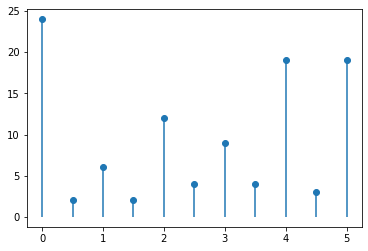

In [4]:
vals, cts = np.unique(data.H2O2, return_counts=True)
plt.plot(vals, cts, 'o')
plt.vlines(vals, ymin=0, ymax=cts)
pass

In [5]:
data.SSK1 = data.SSK1.astype(int)
data.SSK2 = data.SSK2.astype(int)
data.RIC8 = data.RIC8.astype(int)

In [6]:
ssk1 = data.SSK1.to_numpy().reshape(-1,1)
ssk2 = data.SSK2.to_numpy().reshape(-1,1)
ric8 = data.RIC8.to_numpy().reshape(-1,1)
h2o2 = data.H2O2.to_numpy().reshape(-1,1)

In [7]:
# encode two- and three-locus genotypes
ssk1ssk2 = ssk1 + 2 * ssk2
ssk1ric8 = ssk1 + 2 * ric8
ssk2ric8 = ssk2 + 2 * ric8
ssk1ssk2ric8 = ssk1 + 2*ssk2 + 4*ric8

## Analysis based on binary H2O2 (sensitive, resistant)

In [8]:
threshold = 2.5

H2O2 = h2o2 >= threshold
H2O2 = H2O2.astype(int)
H2O2.reshape(-1,1)

MIobs = fs.mutual_info_classif(np.hstack((H2O2,
                                  ssk1,ssk2,ric8,
                                  ssk1ssk2, ssk1ric8, ssk2ric8,
                                  ssk1ssk2ric8)), H2O2.ravel(),
                      discrete_features=True)

# label MIs
MI_ssk1 = MIobs[1]
MI_ssk2 = MIobs[2]
MI_ric8 = MIobs[3]
MI_ssk1ssk2 = MIobs[4]
MI_ssk1ric8 = MIobs[5]
MI_ssk2ric8 = MIobs[6]
MI_ssk1ssk2ric8 = MIobs[7]

entropy_H2O2 = MIobs[0]

# IGstrict of Hu et al
IG_ssk1ssk2 = MI_ssk1ssk2 - MI_ssk1 - MI_ssk2
IG_ssk1ric8 = MI_ssk1ric8 - MI_ssk1 - MI_ric8
IG_ssk2ric8 = MI_ssk2ric8 - MI_ssk2 - MI_ric8
IG_ssk1ssk2ric8 =  MI_ssk1ssk2ric8 - np.maximum(IG_ssk1ssk2, 0) \
    - np.maximum(IG_ssk1ric8,0) \
    - np.maximum(IG_ssk2ric8, 0) \
    - MI_ssk1 - MI_ssk2 - MI_ric8



In [9]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    permgenos = np.random.permutation(origgenos)
    pssk1 = permgenos[:,0]
    pssk2 = permgenos[:,1]
    pric8 = permgenos[:,2]
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((H2O2,
                                  pssk1,pssk2,pric8,
                                  pssk1ssk2, pssk1ric8, pssk2ric8,
                                  pssk1ssk2ric8)), H2O2.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]
MI_pssk1ssk2 = MIperm[:,4]
MI_pssk1ric8 = MIperm[:,5]
MI_pssk2ric8 = MIperm[:,6]
MI_pssk1ssk2ric8 = MIperm[:,7]

zeros = np.zeros_like(MI_pssk1)

# IGstrict for permuted data
IG_pssk1ssk2 = MI_pssk1ssk2 - MI_pssk1 - MI_pssk2
IG_pssk1ric8 = MI_pssk1ric8 - MI_pssk1 - MI_pric8
IG_pssk2ric8 = MI_pssk2ric8 - MI_pssk2 - MI_pric8
IG_pssk1ssk2ric8 =  MI_pssk1ssk2ric8 - np.maximum(IG_pssk1ssk2, zeros) \
    - np.maximum(IG_pssk1ric8, zeros) \
    - np.maximum(IG_pssk2ric8, zeros) \
    - MI_pssk1 - MI_pssk2 - MI_pric8



### 3-way IG

0.049230252853428746
p-value:  0.004


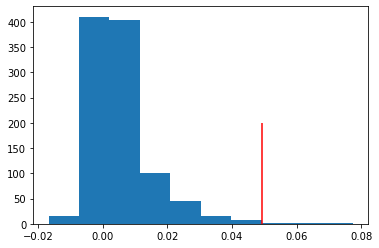

In [10]:
plt.hist(IG_pssk1ssk2ric8)
plt.vlines(IG_ssk1ssk2ric8, ymin=0, ymax=200, color='r')
print(IG_ssk1ssk2ric8)
print("p-value: ", np.sum(IG_pssk1ssk2ric8 > IG_ssk1ssk2ric8)/float(len(IG_pssk1ssk2ric8)))

### 2-way IGs

-0.0007026562631989169
p-value:  0.976


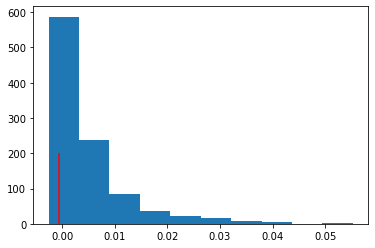

In [11]:
plt.hist(IG_pssk1ssk2)
plt.vlines(IG_ssk1ssk2, ymin=0, ymax=200, color='r')
print(IG_ssk1ssk2)
print("p-value: ", np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2)))

0.005659744081176213
p-value:  0.28


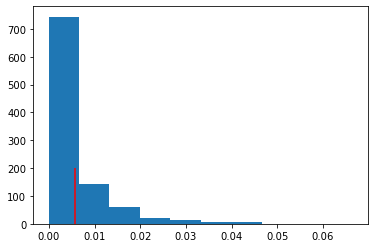

In [12]:
plt.hist(IG_pssk1ric8)
plt.vlines(IG_ssk1ric8, ymin=0, ymax=200, color='r')
print(IG_ssk1ric8)
print("p-value: ", np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8)))

-0.006428359773575115
p-value:  0.994


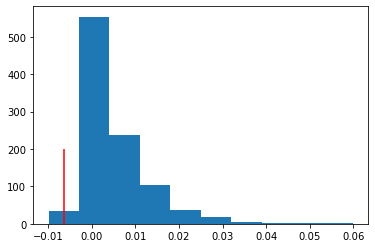

In [13]:
plt.hist(IG_pssk2ric8)
plt.vlines(IG_ssk2ric8, ymin=0, ymax=200, color='r')
print(IG_ssk2ric8)
print("p-value: ", np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8)))

### Main effect MIs

0.029683778475350947
p-value:  0.014


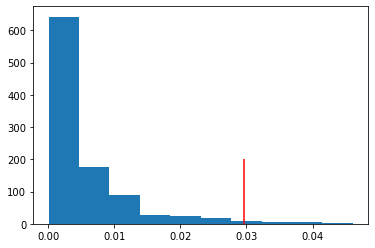

In [14]:
plt.hist(MI_pssk1)
plt.vlines(MI_ssk1, ymin=0, ymax=200, color='r')
print(MI_ssk1)
print("p-value: ", np.sum(MI_pssk1 > MI_ssk1)/float(len(MI_pssk1)))

0.03202938274924372
p-value: 0.012


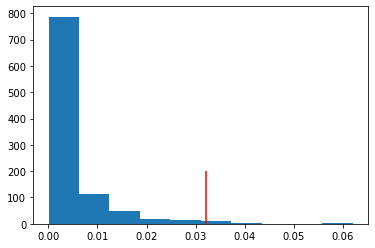

In [15]:
plt.hist(MI_pssk2)
plt.vlines(MI_ssk2, ymin=0, ymax=200, color='r')
print(MI_ssk2)
print("p-value:", np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)))

0.04514264892317507
p-value: 0.0


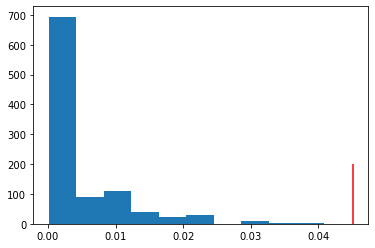

In [16]:
plt.hist(MI_pric8)
plt.vlines(MI_ric8, ymin=0, ymax=200, color='r')
print(MI_ric8)
print("p-value:", np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)))

## Analysis based on ternary H2O2 (sensitive, intermediate, resistant)

In [17]:
lowthreshold = 2
hithreshold = 4

low = h2o2 < lowthreshold
low = low.astype(int) * -1

middle = np.logical_and(h2o2 >= lowthreshold, h2o2 < hithreshold)
middle = middle.astype(int) * 1

high = h2o2 >= hithreshold
high = high.astype(int) * 2

H2O2 = low + middle + high
H2O2 = np.where(H2O2 >= 0, H2O2, 0)
H2O2.reshape(-1,1)
pass

In [18]:
np.sum(high != 0)

41

In [19]:
np.sum(middle!=0)

29

In [20]:
np.sum(low!=0)

34

In [21]:
34 + 34 + 36

104

In [22]:
len(middle)

104

In [23]:

MIobs = fs.mutual_info_classif(np.hstack((H2O2,
                                  ssk1,ssk2,ric8,
                                  ssk1ssk2, ssk1ric8, ssk2ric8,
                                  ssk1ssk2ric8)), H2O2.ravel(),
                      discrete_features=True)

# label MIs
MI_ssk1 = MIobs[1]
MI_ssk2 = MIobs[2]
MI_ric8 = MIobs[3]
MI_ssk1ssk2 = MIobs[4]
MI_ssk1ric8 = MIobs[5]
MI_ssk2ric8 = MIobs[6]
MI_ssk1ssk2ric8 = MIobs[7]

entropy_H2O2 = MIobs[0]

# IGstrict of Hu et al
IG_ssk1ssk2 = MI_ssk1ssk2 - MI_ssk1 - MI_ssk2
IG_ssk1ric8 = MI_ssk1ric8 - MI_ssk1 - MI_ric8
IG_ssk2ric8 = MI_ssk2ric8 - MI_ssk2 - MI_ric8
IG_ssk1ssk2ric8 =  MI_ssk1ssk2ric8 - np.maximum(IG_ssk1ssk2, 0) \
    - np.maximum(IG_ssk1ric8,0) \
    - np.maximum(IG_ssk2ric8, 0) \
    - MI_ssk1 - MI_ssk2 - MI_ric8


In [24]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    permgenos = np.random.permutation(origgenos)
    pssk1 = permgenos[:,0]
    pssk2 = permgenos[:,1]
    pric8 = permgenos[:,2]
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((H2O2,
                                  pssk1,pssk2,pric8,
                                  pssk1ssk2, pssk1ric8, pssk2ric8,
                                  pssk1ssk2ric8)), H2O2.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]
MI_pssk1ssk2 = MIperm[:,4]
MI_pssk1ric8 = MIperm[:,5]
MI_pssk2ric8 = MIperm[:,6]
MI_pssk1ssk2ric8 = MIperm[:,7]

zeros = np.zeros_like(MI_pssk1)

# IGstrict for permuted data
IG_pssk1ssk2 = MI_pssk1ssk2 - MI_pssk1 - MI_pssk2
IG_pssk1ric8 = MI_pssk1ric8 - MI_pssk1 - MI_pric8
IG_pssk2ric8 = MI_pssk2ric8 - MI_pssk2 - MI_pric8
IG_pssk1ssk2ric8 =  MI_pssk1ssk2ric8 - np.maximum(IG_pssk1ssk2, zeros) \
    - np.maximum(IG_pssk1ric8, zeros) \
    - np.maximum(IG_pssk2ric8, zeros) \
    - MI_pssk1 - MI_pssk2 - MI_pric8

0.26934426312855114
p-value:  0.0


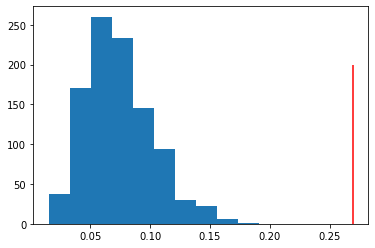

In [25]:
plt.hist(MI_pssk1ssk2ric8)
plt.vlines(MI_ssk1ssk2ric8,0,200,color='r');
print(MI_ssk1ssk2ric8)
print("p-value: ", np.sum(MI_pssk1ssk2ric8 > MI_ssk1ssk2ric8)/float(len(MI_pssk1ssk2ric8)))

### 3-way IG

In [26]:
pwd

'/home/croth/crypto-QTL-paper/SCRIPTS'

0.06900359953353838
p-value:  0.004


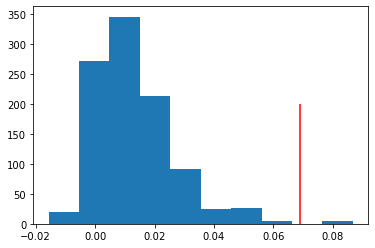

In [27]:
plt.hist(IG_pssk1ssk2ric8)
plt.vlines(IG_ssk1ssk2ric8, ymin=0, ymax=200, color='r')
print(IG_ssk1ssk2ric8)
print("p-value: ", np.sum(IG_pssk1ssk2ric8 > IG_ssk1ssk2ric8)/float(len(IG_pssk1ssk2ric8)))

### 2-way IGs

p-value:  1.0


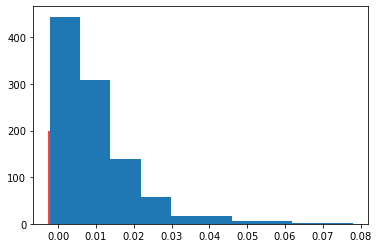

In [28]:
plt.hist(IG_pssk1ssk2)
plt.vlines(IG_ssk1ssk2, ymin=0, ymax=200, color='r')
print("p-value: ", np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2)))

p-value:  0.151


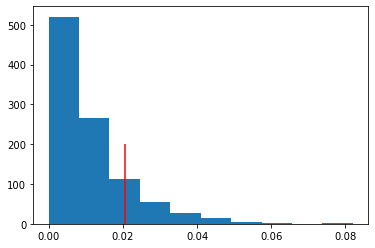

In [29]:
plt.hist(IG_pssk1ric8)
plt.vlines(IG_ssk1ric8, ymin=0, ymax=200, color='r')
print("p-value: ", np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8)))

p-value:  0.493


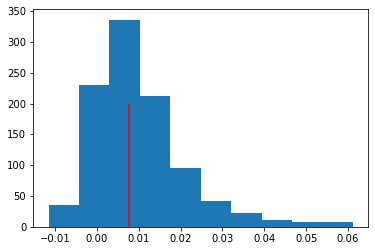

In [30]:
plt.hist(IG_pssk2ric8)
plt.vlines(IG_ssk2ric8, ymin=0, ymax=200, color='r')
print("p-value: ", np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8)))

### Main effect MIs

0.0411082805376069
p-value:  0.023


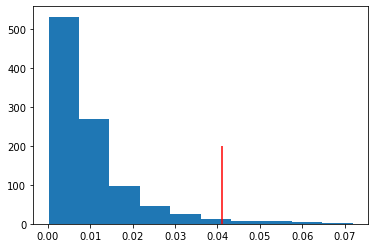

In [31]:
plt.hist(MI_pssk1)
plt.vlines(MI_ssk1, ymin=0, ymax=200, color='r')
print(MI_ssk1)
print("p-value: ", np.sum(MI_pssk1 > MI_ssk1)/float(len(MI_pssk1)))

0.06902070838156217
p-value:  0.001


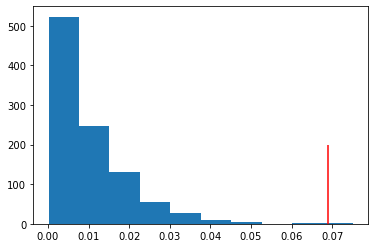

In [32]:
plt.hist(MI_pssk2)
plt.vlines(MI_ssk2, ymin=0, ymax=200, color='r')
print(MI_ssk2)
print("p-value: ", np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)))

0.06210185103050134
p-value:  0.002


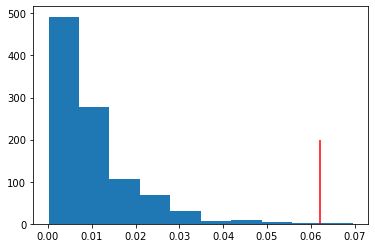

In [33]:
plt.hist(MI_pric8)
plt.vlines(MI_ric8, ymin=0, ymax=200, color='r')
print(MI_ric8)
print("p-value: ", np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)))